<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Import Required libraries</b></font>
</p>

In [7]:
import torch
import numpy as np
import time
import os
import sys
import pickle
from PIL import Image
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt

# Import the model definition
sys.path.append('/kaggle/input/siamese-model')
from siamese_model import SiameseNetwork

print('libraries were imported successfully')

libraries were imported successfully


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Check for GPU</b></font>
</p>

In [8]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define transforms for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

Using device: cuda


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Loading model</b></font>
</p>

In [9]:
# Dictionary to store registered fingerprints
registered_users = {}

def load_model(model_path='FingerPrint.pth'):
    """Load the trained model"""
    model = torch.load(model_path, map_location=device)
    model.eval()  # Set model to evaluation mode
    return model

model_path = '/kaggle/input/model-and-finger-prints-sample/FingerPrint_30_epochs.pth'
model = load_model(model_path)
print(f"\nModel {model_path.split('/')[1]} was loaded successfully!\n")

/tmp/ipykernel_31/1712436278.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)



Model kaggle was loaded successfully!



<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Model summary</b></font>
</p>

In [10]:
# Show summary of one branch only (shared across both inputs)
print("🔍 Backbone : Resnet18")

print("\n🔍 FC Head Summary:")
summary(model.fc, input_size=(512,), device=str(device))  # 512 is resnet18's output size

🔍 Backbone : Resnet18

🔍 FC Head Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         131,328
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
Total params: 164,224
Trainable params: 164,224
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.63
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Defining register function</b></font>
</p>

In [11]:
def register_fingerprint(user_id, fingerprint_image, model, transform=None):
    """ Register a new fingerprint for a user """
    # Move model to eval mode
    model.eval()
    with torch.no_grad():
        # Preprocess
        if transform:
            fingerprint_image = transform(fingerprint_image)
        # Expand batch dimension
        fingerprint_image = fingerprint_image.unsqueeze(0).to(device)
        # Get embedding
        embedding = model.forward_once(fingerprint_image).cpu().numpy().flatten()
        
        if user_id not in registered_users:
            registered_users[user_id] = []
    
        registered_users[user_id].append(embedding)

<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Defining recognize function</b></font>
</p>

In [12]:
def recognize_fingerprint(fingerprint_image, model, transform=None, threshold=0.1):
    """
    Recognize a fingerprint by comparing against stored user embeddings.
    Returns the user ID if matched, otherwise 'Unknown'.
    """
    # Move model to eval mode
    model.eval()
    start_time = time.time()
    
    with torch.no_grad():
        if transform:
            fingerprint_image = transform(fingerprint_image)
        fingerprint_image = fingerprint_image.unsqueeze(0).to(device)
        embedding = model.forward_once(fingerprint_image).cpu().numpy().flatten()

    best_user = "Unknown"
    best_dist = float("inf")

    for user_id, emb_list in registered_users.items():
        for ref_emb in emb_list:
            dist = np.linalg.norm(embedding - ref_emb)
            if dist < best_dist:
                best_dist = dist
                best_user = user_id

    # If best distance is above threshold, we say 'Unknown'
    if best_dist > threshold:
        best_user = "Unknown"
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    # print(f"Recognition time: {elapsed_time:.4f} seconds")

    return best_user, elapsed_time

<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Registering users</b></font>
</p>

In [15]:
registered_users = {}

def get_image_for_regester(path):
    img = Image.open(path).convert("L")
    return img

fingerprints_path = '/kaggle/input/model-and-finger-prints-sample/user_finger_prints/user_finger_prints'
# Register some fingerprints
users_to_register = [user.split('.')[0] for user in os.listdir(fingerprints_path) if user.endswith('.png')][:10]
for i, user_id in enumerate(users_to_register):
    img_name = users_to_register[i] + ".png"
    img_path = os.path.join(fingerprints_path, img_name)
    img = get_image_for_regester(img_path)
    register_fingerprint(user_id, img, model, transform=transform)

print("Registered Users:", list(registered_users.keys()))

Registered Users: ['user01', 'user05', 'user06', 'user10', 'user03', 'user16', 'user15', 'user02', 'user11', 'user13']


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Display registered fingerprints</b></font>
</p>

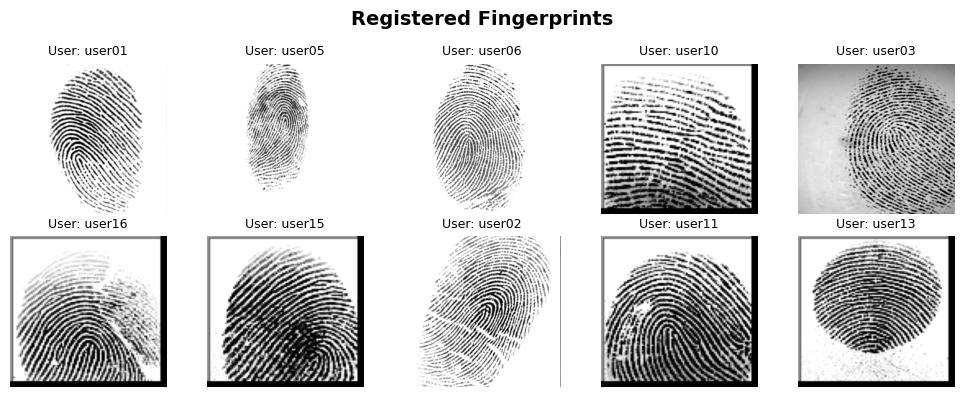

In [17]:
# Display registered fingerprints in a grid
plt.figure(figsize=(10, 4))
num_cols = 5
num_rows = (len(users_to_register) + num_cols - 1) // num_cols

for i, user_id in enumerate(users_to_register):
    img_path = os.path.join(fingerprints_path, user_id + ".png")
    img = Image.open(img_path).convert("L")

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"User: {user_id}", fontsize=9)
    plt.axis("off")

plt.suptitle("Registered Fingerprints", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Saving registered finger prints to a file</b></font>
</p>

In [18]:
def save_registered_users(file_path="registered_users.pkl"):
    with open(file_path, "wb") as f:
        pickle.dump(registered_users, f)
save_registered_users()
print("Registered users saved to", "registered_users.pkl")

Registered users saved to registered_users.pkl


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Loading registered finger prints</b></font>
</p>

In [19]:
def load_registered_users(file_path="registered_users.pkl"):
    global registered_users
    if os.path.exists(file_path):
        with open(file_path, "rb") as f:
            registered_users = pickle.load(f)
    else:
        registered_users = {}
        print("No registered users found. Starting fresh.")

load_registered_users()
print("Loaded registered users:", list(registered_users.keys()))

Loaded registered users: ['user01', 'user05', 'user06', 'user10', 'user03', 'user16', 'user15', 'user02', 'user11', 'user13']


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Detecting finger prints</b></font>
</p>

<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>10 registered + 6 unregistered</b></font>
</p>

In [24]:
RED = "\033[91m"
GREEN = "\033[92m"
RESET = "\033[0m"

predictions = {}
elapsed_times = []
for user_id in os.listdir(fingerprints_path):
    img_path = os.path.join(fingerprints_path, user_id)
    img_to_recognize = get_image_for_regester(img_path)
    predicted_user, elapsed_time = recognize_fingerprint(img_to_recognize, model, transform=transform, threshold=0.03)
    elapsed_times.append(elapsed_time)
    user_id = user_id.split('.')[0]
    predictions[user_id] = predicted_user

counter = 0
results= []
for user_id, pred in predictions.items():
    if user_id in list(registered_users.keys()) and pred == user_id:
        counter += 1
        results.append([user_id, pred, 'Correct'])
        print(f"{GREEN}{user_id}: {pred}{RESET}")
    elif pred == 'Unknown' and user_id not in list(registered_users.keys()):
        counter += 1
        results.append([user_id, pred, 'Unknown'])
        print(f"{GREEN}{user_id}: {pred}{RESET}")
    else:
        results.append([user_id, pred, 'Wrong'])
        print(f"{RED}{user_id}: {pred}{RESET}")
avg_time = sum(elapsed_times) / len(elapsed_times)

print('-' * 15)
print(f"Accuracy of recognition: {counter/len(predictions)*100:.2f}%")
print(f"Average recognition time: {avg_time:.4f} seconds")
    

user01: user01
user05: user05
user06: user06
user10: user10
user03: user03
user16: user16
user15: user15
user02: user02
user11: user11
user13: user13
user12: Unknown
user09: Unknown
user04: user02
user08: Unknown
user07: Unknown
user14: Unknown
---------------
Accuracy of recognition: 93.75%
Average recognition time: 0.0055 seconds


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Displaying results</b></font>
</p>

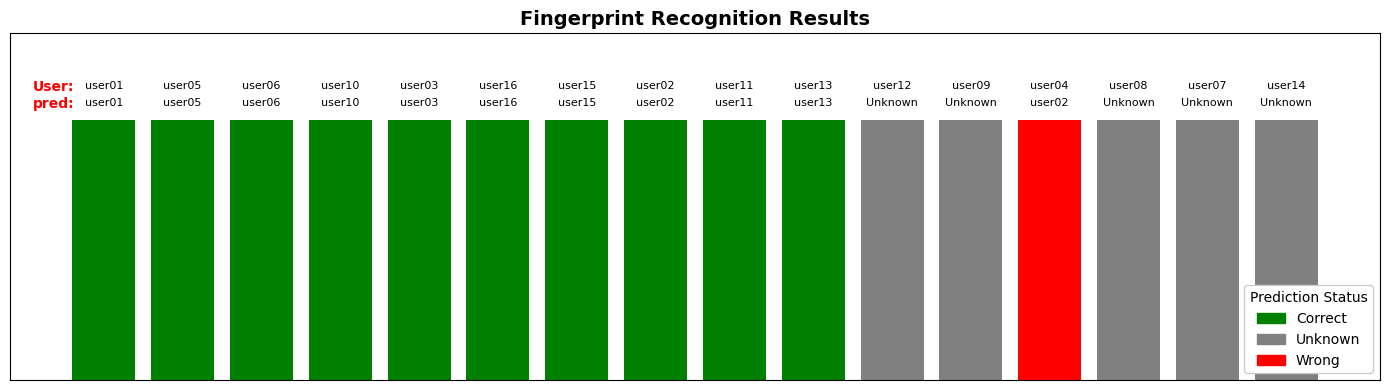

/tmp/ipykernel_31/1939670107.py:31: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  plt.tight_layout()


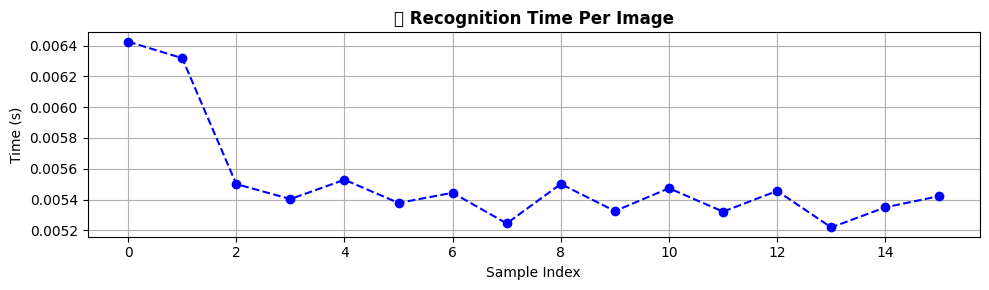

In [26]:
fig, ax = plt.subplots(figsize=(14, 4))

colors = {'Correct': 'green', 'Unknown': 'gray', 'Wrong': 'red'}

# Plot each bar and add rotated labels
for idx, (user_id, pred, status) in enumerate(results):
    ax.bar(idx, 0.9, color=colors[status])
    ax.text(idx, 1, f"{user_id}", ha='center', va='bottom', fontsize=8)
    ax.text(idx, 0.94, f"{pred}", ha='center', va='bottom', fontsize=8)

ax.text(-0.9, 1, 'User:', fontsize=10, color='red', ha='left', fontweight='bold')
ax.text(-0.9, 0.94, 'pred:', fontsize=10, color='red', ha='left', fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, 1.2)
ax.set_title("Fingerprint Recognition Results", fontsize=14, weight='bold')

legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
plt.legend(legend_handles, colors.keys(), title="Prediction Status", loc="lower right", framealpha=1.0)
plt.tight_layout()
plt.show()


# Plot recognition time
plt.figure(figsize=(10, 3))
plt.plot(elapsed_times, marker='o', linestyle='--', color='blue')
plt.title("⏱️ Recognition Time Per Image", fontsize=12, weight='bold')
plt.xlabel("Sample Index")
plt.ylabel("Time (s)")
plt.grid(True)
plt.tight_layout()
plt.show()
